# Packages and Libraries

In [1]:
import os
import json
import math
import wave
import pathlib

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


import tensorflow as tf 
from tensorflow.keras import layers, models
import tensorflow.keras as keras

import librosa
import IPython.display as display
import soundfile as sf

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

2024-02-15 14:06:19.075521: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-15 14:06:19.337749: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-15 14:06:19.337958: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-15 14:06:19.368858: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-15 14:06:19.443985: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-15 14:06:19.445243: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [2]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# Loading Raw Audio Data

The dataset's audio clips are of 6 classes and stored in six folders corresponding to each speech command: 
- `ddyo`
- `kkono`
- `mu maaso`
- `emabega`
- `yimirira`
- `gaali`

## Mount google drive
adisamproject@gmail.com

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')
# DATASET_PATH = "/content/drive/My Drive/2_Luganda/dataset"
# data_dir = pathlib.Path(DATASET_PATH)

### On colab Notebooks
uncomment these lines for loading in data

### Locally on the pc

In [5]:
DATASET_PATH = 'own/'
data_dir = pathlib.Path(DATASET_PATH)
OUTPUT_PATH = 'output/'

# Inspect the audio data

## Label Names

In [6]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
print('Commands:', commands)

Commands: ['emabega' 'ddyo' 'gaali' 'kkono' 'mu masso' 'yimirira']


## Insect one audio file

In [7]:
example_audio_path = 'own/ddyo/audio #2001.wav'
audio_signal, sample_rate = librosa.load(example_audio_path)

In [8]:
audio = wave.open(example_audio_path, 'rb')

### Audio Parameters

In [9]:
number_of_channel = audio.getnchannels()
sample_width = audio.getsampwidth()
frame_rate = audio.getframerate()
number_of_frames = audio.getnframes()

In [10]:
print('Number of channels:', number_of_channel)
print('Sample width:',       sample_width)
print('frame rate:',         frame_rate)
print('Number of frames:',   number_of_frames)
print('Parameters:',         audio.getparams())

Number of channels: 1
Sample width: 2
frame rate: 16000
Number of frames: 15360
Parameters: _wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=15360, comptype='NONE', compname='not compressed')


In [11]:
duration = librosa.get_duration(y=audio_signal, sr=sample_rate)
print(f"Duration: {duration} seconds")
print(f"Sample Rate: {sample_rate} Hz")

Duration: 0.96 seconds
Sample Rate: 22050 Hz


### Visualize the audio waveform

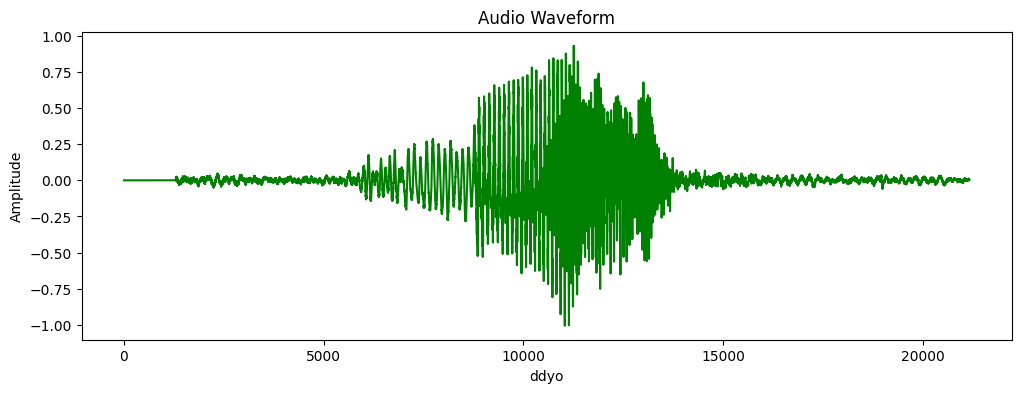

In [12]:
plt.figure(figsize=(12, 4))
plt.plot(audio_signal, color='green')
plt.title('Audio Waveform')
plt.xlabel('ddyo')
plt.ylabel('Amplitude')
plt.show()

### Amplitude Distribution

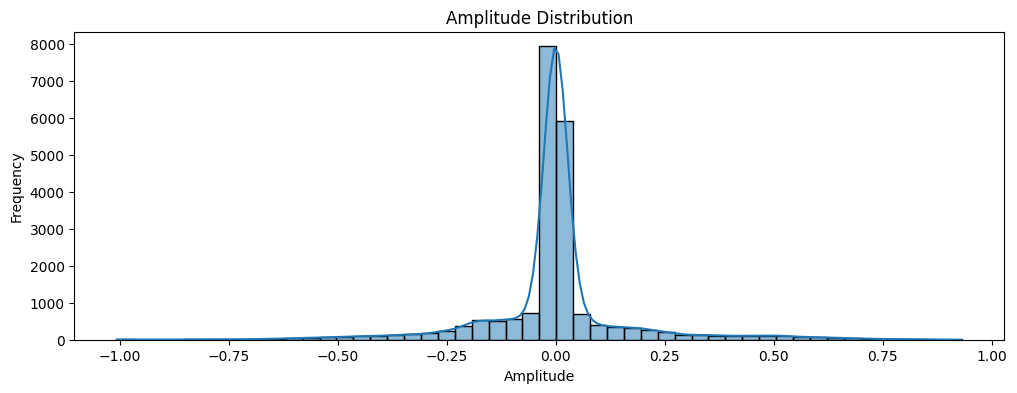

In [13]:
plt.figure(figsize=(12, 4))
sns.histplot(audio_signal, bins=50, kde=True)
plt.title('Amplitude Distribution')
plt.xlabel('Amplitude')
plt.ylabel('Frequency')
plt.show()


## Number of audio files per command

In [14]:
def count_audio_files_in_subfolders(data_dir):
    counts = {}

    # Iterate through subfolders
    for subfolder in os.listdir(data_dir):
        subfolder_path = os.path.join(data_dir, subfolder)

        # Check if it's a directory
        if os.path.isdir(subfolder_path):
            # Count the number of audio files in the subfolder
            audio_files_count = len([f for f in os.listdir(subfolder_path) if f.endswith('.wav')])
            counts[subfolder] = audio_files_count

    return counts

# Get the counts
counts = count_audio_files_in_subfolders(data_dir)
counts

{'emabega': 600,
 'ddyo': 600,
 'gaali': 600,
 'kkono': 600,
 'mu masso': 600,
 'yimirira': 600}

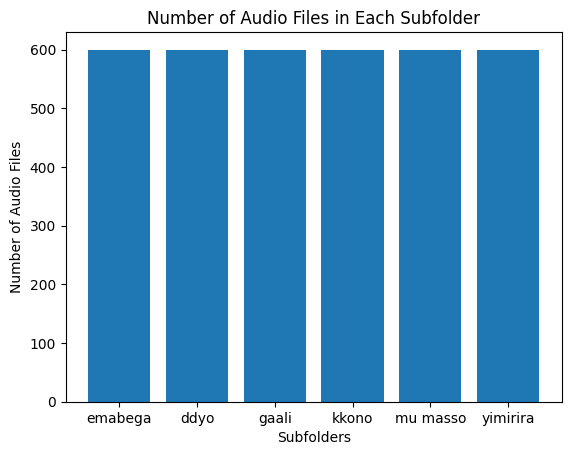

In [15]:
### Bar graph showing number of audio files per command
plt.bar(counts.keys(), counts.values())
plt.xlabel('Subfolders')
plt.ylabel('Number of Audio Files')
plt.title('Number of Audio Files in Each Subfolder')
plt.show()

# Split into Train and validation

In [16]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=16000,
    subset='both')

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

Found 3600 files belonging to 6 classes.
Using 2880 files for training.
Using 720 files for validation.

label names: ['ddyo' 'emabega' 'gaali' 'kkono' 'mu masso' 'yimirira']


### The audio clips have a shape of `(batch, samples, channels)`.

In [17]:
train_ds.element_spec

(TensorSpec(shape=(None, 16000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [18]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

In [19]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [20]:
for example_audio, example_labels in train_ds.take(1):
  print(example_audio.shape)
  print(example_labels.shape)

(64, 16000)
(64,)


### Plot a few audio waveforms:

In [21]:
label_names[[1,2,3,0,4,5]]

array(['emabega', 'gaali', 'kkono', 'ddyo', 'mu masso', 'yimirira'],
      dtype='<U8')

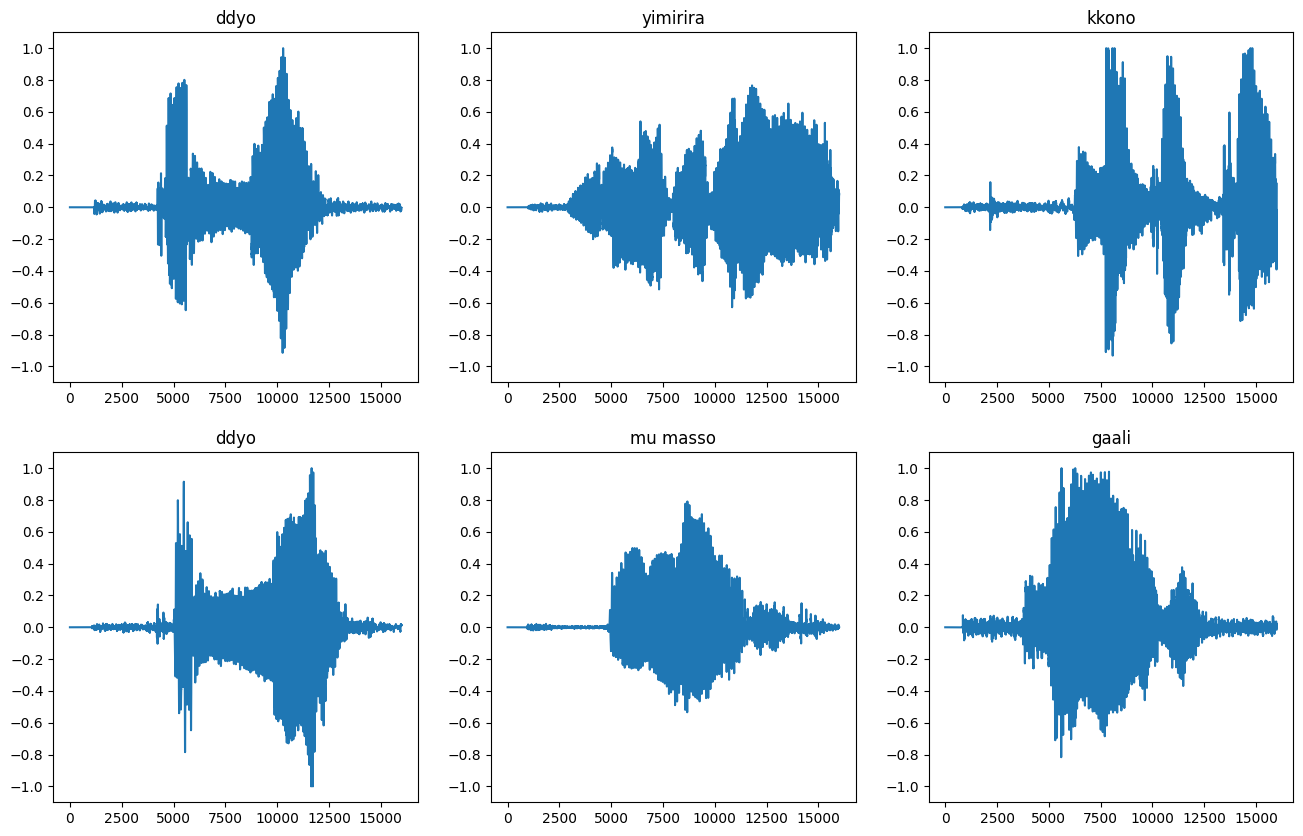

In [22]:
plt.figure(figsize=(16, 10))
rows = 2
cols = 3
n = rows * cols
for i in range(n):
  plt.subplot(rows, cols, i+1)
  audio_signal = example_audio[i]
  plt.plot(audio_signal)
  plt.title(label_names[example_labels[i]])
  plt.yticks(np.arange(-1.2, 1.2, 0.2))
  plt.ylim([-1.1, 1.1])

In [23]:
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

### The shapes of a tensorized waveform and the corresponding spectrogram, and play the original audio:

In [24]:
for i in range(3):
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=16000))

Label: ddyo
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: yimirira
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: kkono
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


### Displaying a spectrogram:

In [25]:
# Convert the frequencies to log scale and transpose, so that the time is
# represented on the x-axis (columns).
# Add an epsilon to avoid taking a log of zero.

def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
      
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

### Plot of waveform over time and the corresponding spectrogram.

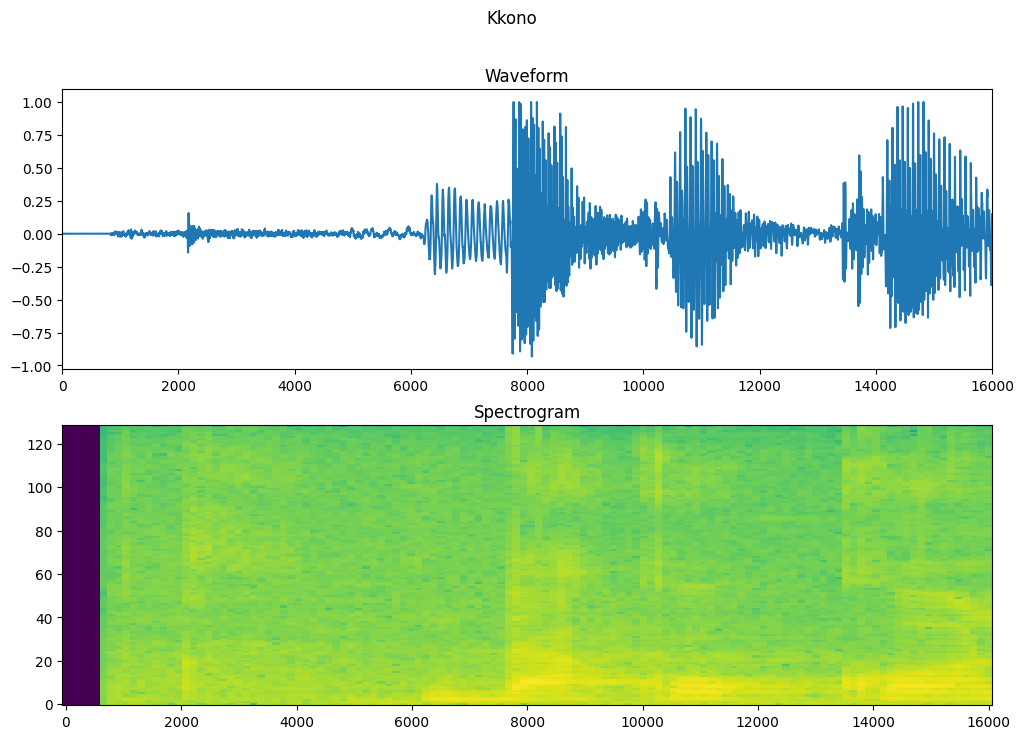

In [26]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

## Create spectrogram datasets from the audio datasets:

In [27]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [28]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

Examine the spectrograms for different examples of the dataset:

In [29]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

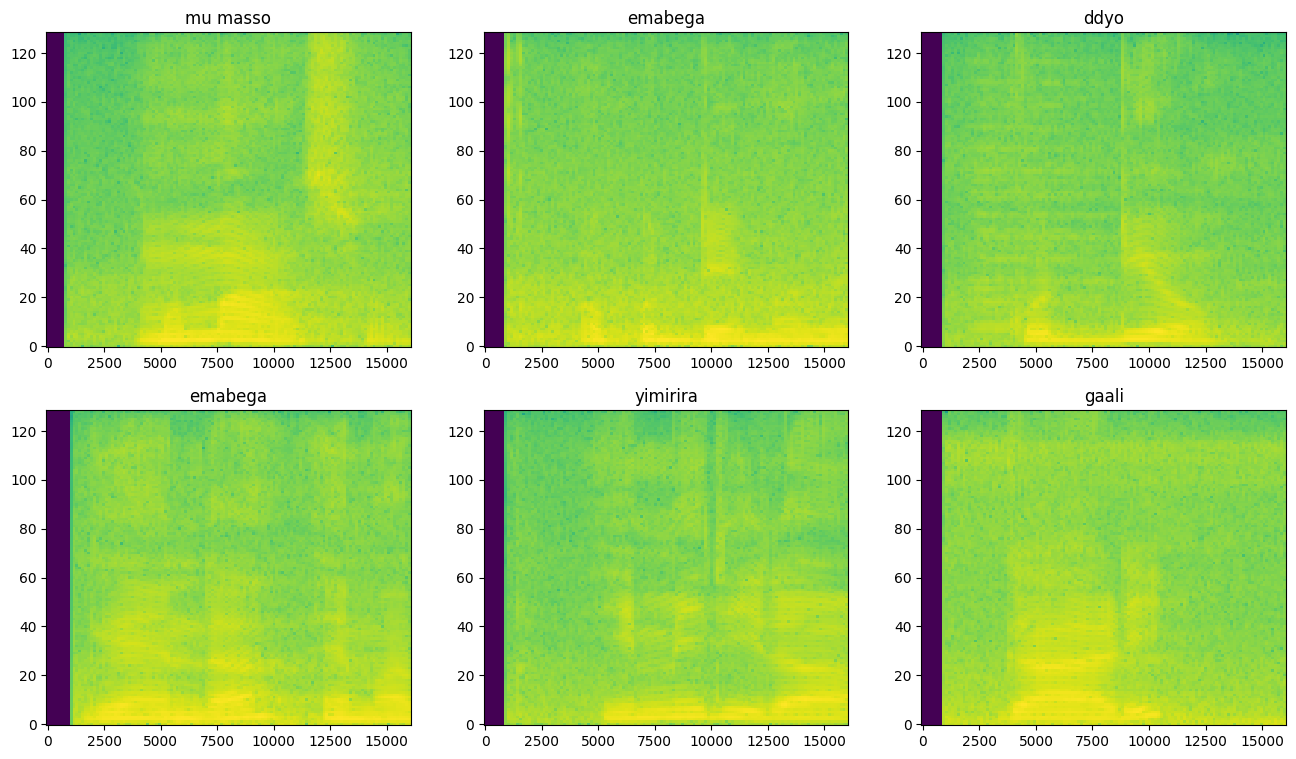

In [30]:
rows = 2
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])

plt.show()

### `Dataset.cache` and `Dataset.prefetch` operations to reduce read latency while training the model:

In [31]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

## Model 1

In [32]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)
norm_layer = layers.Normalization()
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (124, 129, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizati  (None, 32, 32, 1)         3         
 on)                                                             
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           

### Keras model with the Adam optimizer and the cross-entropy loss:

In [33]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

### Train the model

In [34]:
EPOCHS = 10
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10
45/45 [==============================] - 12s 204ms/step - loss: 0.7705 - accuracy: 0.7066 - val_loss: 0.2877 - val_accuracy: 0.9196
Epoch 2/10
45/45 [==============================] - 8s 180ms/step - loss: 0.2982 - accuracy: 0.8976 - val_loss: 0.1799 - val_accuracy: 0.9345
Epoch 3/10
45/45 [==============================] - 8s 180ms/step - loss: 0.1919 - accuracy: 0.9299 - val_loss: 0.1230 - val_accuracy: 0.9583
Epoch 4/10
45/45 [==============================] - 8s 182ms/step - loss: 0.1269 - accuracy: 0.9552 - val_loss: 0.1125 - val_accuracy: 0.9583
Epoch 5/10
45/45 [==============================] - 8s 179ms/step - loss: 0.1056 - accuracy: 0.9639 - val_loss: 0.1126 - val_accuracy: 0.9613
Epoch 6/10
45/45 [==============================] - 8s 179ms/step - loss: 0.0889 - accuracy: 0.9698 - val_loss: 0.0971 - val_accuracy: 0.9732
Epoch 7/10
45/45 [==============================] - 8s 180ms/step - loss: 0.0850 - accuracy: 0.9743 - val_loss: 0.0956 - val_accuracy: 0.9732
Epoch

### Plot the training and validation loss curves to check how your model has improved during training:

Text(0, 0.5, 'Accuracy [%]')

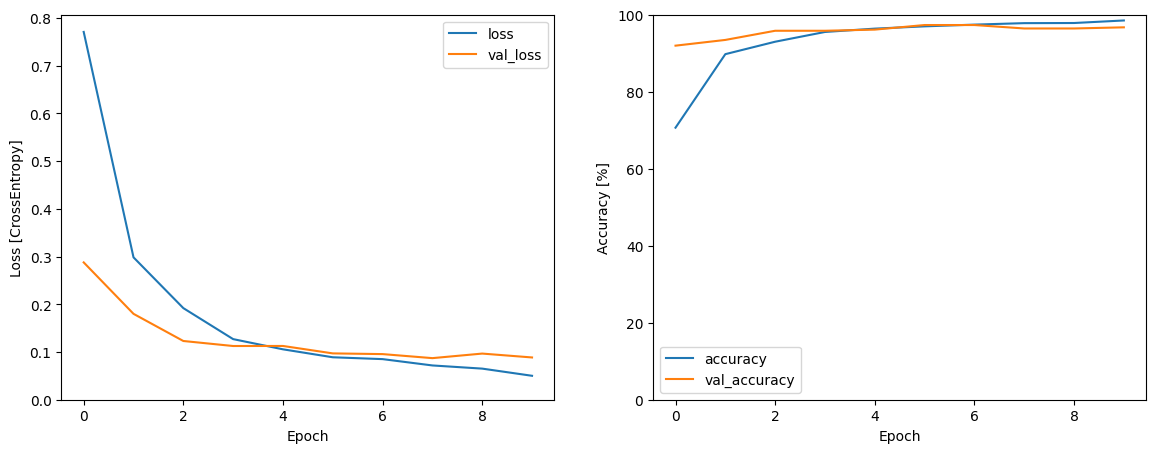

In [35]:
metrics = history.history
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

### Evaluate the model performance

Run the model on the test set and check the model's performance:

In [36]:
model.evaluate(test_spectrogram_ds, return_dict=True)

6/6 [==============================] - 1s 60ms/step - loss: 0.0493 - accuracy: 0.9792


{'loss': 0.04932880029082298, 'accuracy': 0.9791666865348816}

### Display a confusion matrix

In [37]:
y_pred = model.predict(test_spectrogram_ds)

6/6 [==============================] - 0s 41ms/step


In [38]:
y_pred = tf.argmax(y_pred, axis=1)

In [39]:
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

In [4]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

NameError: name 'y_true' is not defined

### Export the model with preprocessing

In [41]:
class ExportModel(tf.Module):
  def __init__(self, model):
    self.model = model

    # Accept either a string-filename or a batch of waveforms.
    # YOu could add additional signatures for a single wave, or a ragged-batch.
    self.__call__.get_concrete_function(
        x=tf.TensorSpec(shape=(), dtype=tf.string))
    self.__call__.get_concrete_function(
       x=tf.TensorSpec(shape=[None, 16000], dtype=tf.float32))


  @tf.function
  def __call__(self, x):
    # If they pass a string, load the file and decode it.
    if x.dtype == tf.string:
      x = tf.io.read_file(x)
      x, _ = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
      x = tf.squeeze(x, axis=-1)
      x = x[tf.newaxis, :]

    x = get_spectrogram(x)
    result = self.model(x, training=False)

    class_ids = tf.argmax(result, axis=-1)
    class_names = tf.gather(label_names, class_ids)
    return {'predictions':result,
            'class_ids': class_ids,
            'class_names': class_names}

## Model 2

In [42]:
model2 = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Resizing(32, 32),
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])


In [43]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_1 (Resizing)       (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizati  (None, 32, 32, 1)         3         
 on)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 30, 30, 32)        320       
                                                                 
 batch_normalization (Batch  (None, 30, 30, 32)        128       
 Normalization)                                                  
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 15, 15, 32)        0         
 g2D)                                                            
                                                      

In [44]:
model2.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

timizer=tf.keras.optimizers.Adam(),
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),


In [45]:
EPOCHS = 10
history = model2.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10
45/45 [==============================] - 9s 98ms/step - loss: 0.9990 - accuracy: 0.6958 - val_loss: 1.3941 - val_accuracy: 0.6577
Epoch 2/10
45/45 [==============================] - 4s 90ms/step - loss: 0.2860 - accuracy: 0.9000 - val_loss: 1.2581 - val_accuracy: 0.5119
Epoch 3/10
45/45 [==============================] - 4s 85ms/step - loss: 0.1923 - accuracy: 0.9333 - val_loss: 1.1484 - val_accuracy: 0.5208
Epoch 4/10
45/45 [==============================] - 4s 87ms/step - loss: 0.1354 - accuracy: 0.9542 - val_loss: 1.1035 - val_accuracy: 0.5208
Epoch 5/10
45/45 [==============================] - 4s 83ms/step - loss: 0.1069 - accuracy: 0.9625 - val_loss: 0.8286 - val_accuracy: 0.7202
Epoch 6/10
45/45 [==============================] - 4s 80ms/step - loss: 0.0866 - accuracy: 0.9691 - val_loss: 1.2746 - val_accuracy: 0.4821
Epoch 7/10
45/45 [==============================] - 4s 90ms/step - loss: 0.0808 - accuracy: 0.9705 - val_loss: 0.8048 - val_accuracy: 0.6696
Epoch 8/10
45

Text(0, 0.5, 'Accuracy [%]')

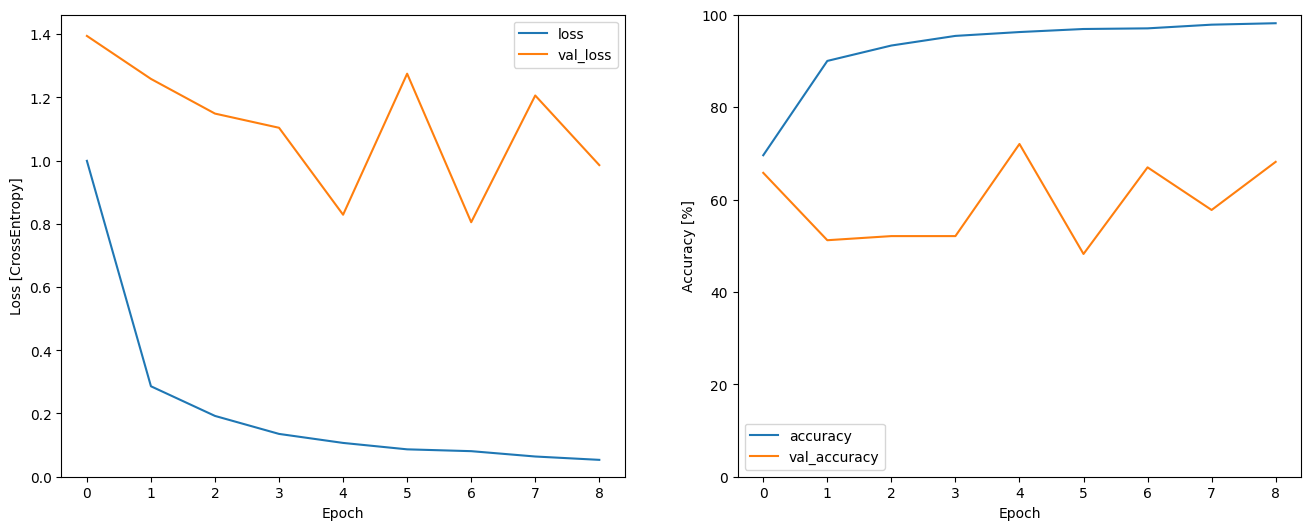

In [46]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

### Evaluate the model

In [47]:
model2.evaluate(test_spectrogram_ds, return_dict=True)

6/6 [==============================] - 0s 30ms/step - loss: 0.9828 - accuracy: 0.6979


{'loss': 0.9827563762664795, 'accuracy': 0.6979166865348816}

In [48]:
y_pred = model2.predict(test_spectrogram_ds)
y_pred = tf.argmax(y_pred, axis=1)

6/6 [==============================] - 0s 23ms/step


In [49]:
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

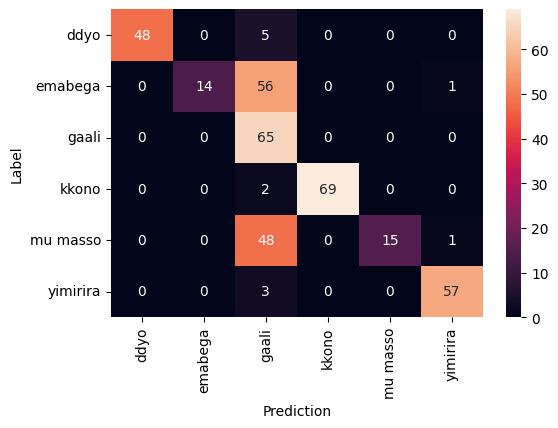

In [50]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

## Model 3

In [51]:
model3 = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Conv2D(32, 3, activation='relu', dilation_rate=(2, 2)),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu', dilation_rate=(2, 2)),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu', dilation_rate=(2, 2)),
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])


In [52]:
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 120, 125, 32)      320       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 60, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 56, 58, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 28, 29, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 24, 25, 128)       73856     
                                                                 
 global_average_pooling2d (  (None, 128)              

In [53]:
model3.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [54]:
EPOCHS = 10
history = model3.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10
45/45 [==============================] - 69s 1s/step - loss: 1.5114 - accuracy: 0.3653 - val_loss: 1.0292 - val_accuracy: 0.6756
Epoch 2/10
45/45 [==============================] - 63s 1s/step - loss: 0.7885 - accuracy: 0.7073 - val_loss: 0.5013 - val_accuracy: 0.8333
Epoch 3/10
45/45 [==============================] - 62s 1s/step - loss: 0.4676 - accuracy: 0.8382 - val_loss: 0.3269 - val_accuracy: 0.8839
Epoch 4/10
45/45 [==============================] - 62s 1s/step - loss: 0.3294 - accuracy: 0.8806 - val_loss: 0.2428 - val_accuracy: 0.9018
Epoch 5/10
45/45 [==============================] - 63s 1s/step - loss: 0.2533 - accuracy: 0.9094 - val_loss: 0.2152 - val_accuracy: 0.9315
Epoch 6/10
45/45 [==============================] - 63s 1s/step - loss: 0.2365 - accuracy: 0.9167 - val_loss: 0.2036 - val_accuracy: 0.9345
Epoch 7/10
45/45 [==============================] - 64s 1s/step - loss: 0.2067 - accuracy: 0.9264 - val_loss: 0.1612 - val_accuracy: 0.9464
Epoch 8/10
45/45 [==

Text(0, 0.5, 'Accuracy [%]')

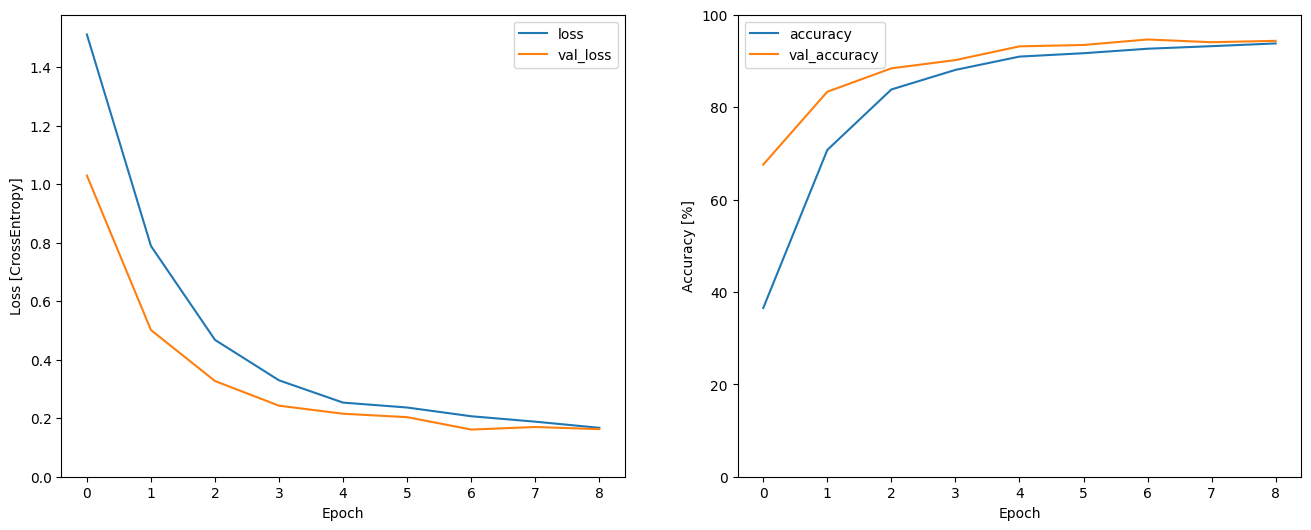

In [55]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

### Evaluate the model

In [56]:
model3.evaluate(test_spectrogram_ds, return_dict=True)

6/6 [==============================] - 3s 546ms/step - loss: 0.1594 - accuracy: 0.9453


{'loss': 0.15940314531326294, 'accuracy': 0.9453125}

In [57]:
y_pred = model3.predict(test_spectrogram_ds)
y_pred = tf.argmax(y_pred, axis=1)

6/6 [==============================] - 4s 559ms/step


In [58]:
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

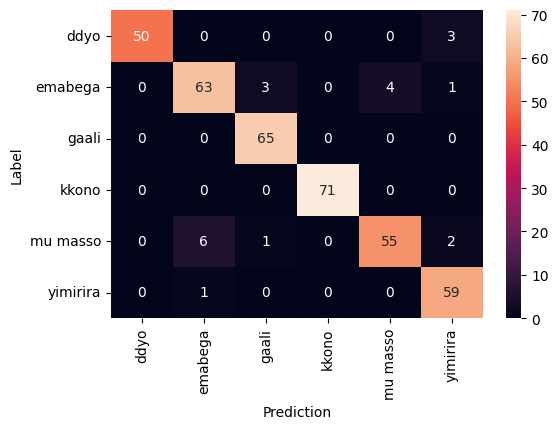

In [59]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

## Model 4

In [60]:

train_spectrogram_ds = train_spectrogram_ds.map(lambda x, y: (tf.image.grayscale_to_rgb(x), y))
val_spectrogram_ds = val_spectrogram_ds.map(lambda x, y: (tf.image.grayscale_to_rgb(x), y))

In [61]:
input_shape = (124, 129, 3) 
base_model = tf.keras.applications.MobileNetV2(
    input_shape=input_shape, include_top=False, weights='imagenet')
base_model.trainable = False

model4 = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])


In [62]:
model4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 4, 5, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_1  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_6 (Dense)             (None, 128)               163968    
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 6)                 774       
                                                                 
Total params: 2422726 (9.24 MB)
Trainable params: 1647

In [63]:
model4.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [64]:
EPOCHS = 10
history = model4.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10
45/45 [==============================] - 35s 607ms/step - loss: 0.7950 - accuracy: 0.7160 - val_loss: 0.3128 - val_accuracy: 0.9048
Epoch 2/10
45/45 [==============================] - 23s 504ms/step - loss: 0.2995 - accuracy: 0.8976 - val_loss: 0.2352 - val_accuracy: 0.9256
Epoch 3/10
45/45 [==============================] - 23s 502ms/step - loss: 0.2094 - accuracy: 0.9319 - val_loss: 0.1890 - val_accuracy: 0.9375
Epoch 4/10
45/45 [==============================] - 23s 509ms/step - loss: 0.1812 - accuracy: 0.9420 - val_loss: 0.1670 - val_accuracy: 0.9405
Epoch 5/10
45/45 [==============================] - 23s 503ms/step - loss: 0.1537 - accuracy: 0.9524 - val_loss: 0.1496 - val_accuracy: 0.9524
Epoch 6/10
45/45 [==============================] - 23s 515ms/step - loss: 0.1212 - accuracy: 0.9552 - val_loss: 0.1520 - val_accuracy: 0.9464
Epoch 7/10
45/45 [==============================] - 22s 497ms/step - loss: 0.1057 - accuracy: 0.9642 - val_loss: 0.1297 - val_accuracy: 0.9583

Text(0, 0.5, 'Accuracy [%]')

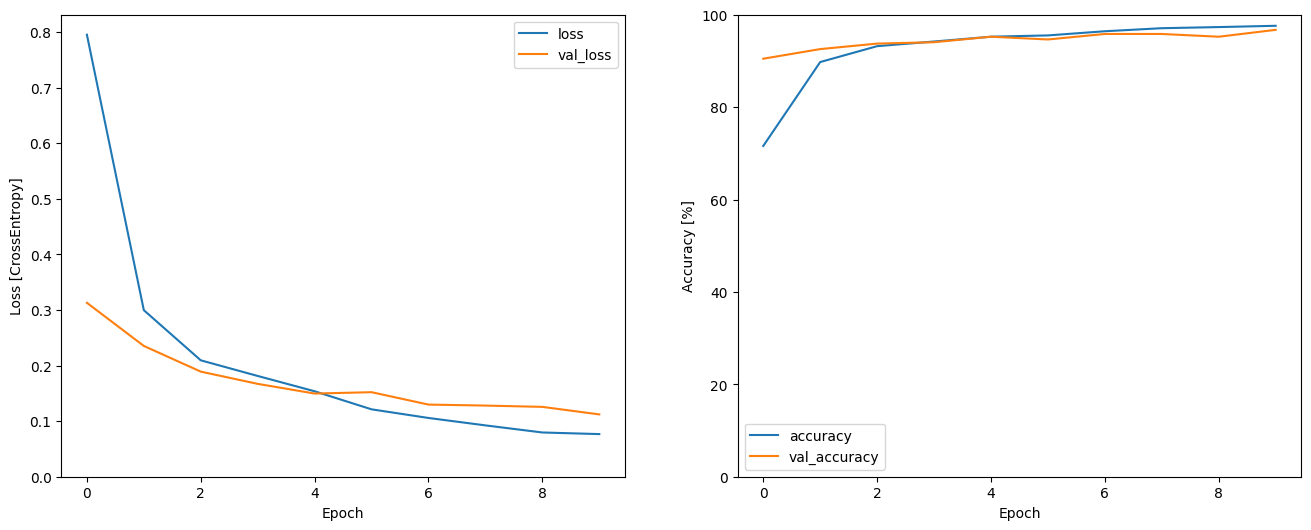

In [65]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

### Evaluate the model

In [66]:
model4.evaluate(val_spectrogram_ds, return_dict=True)


6/6 [==============================] - 3s 400ms/step - loss: 0.1121 - accuracy: 0.9673


{'loss': 0.11207960546016693, 'accuracy': 0.9672619104385376}

In [67]:
y_pred = model4.predict(val_spectrogram_ds)
y_pred = tf.argmax(y_pred, axis=1)

6/6 [==============================] - 5s 401ms/step


In [68]:
y_true = tf.concat(list(val_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

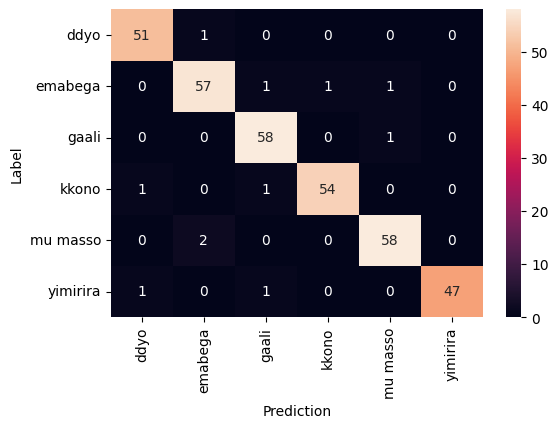

In [69]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

# Exporting a model

## Export the model with preprocessing

In [70]:
class ExportModel(tf.Module):
  def __init__(self, model):
    self.model = model

    # Accept either a string-filename or a batch of waveforms.
    # YOu could add additional signatures for a single wave, or a ragged-batch.
    self.__call__.get_concrete_function(
        x=tf.TensorSpec(shape=(), dtype=tf.string))
    self.__call__.get_concrete_function(
       x=tf.TensorSpec(shape=[None, 16000], dtype=tf.float32))


  @tf.function
  def __call__(self, x):
    # If they pass a string, load the file and decode it.
    if x.dtype == tf.string:
      x = tf.io.read_file(x)
      x, _ = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
      x = tf.squeeze(x, axis=-1)
      x = x[tf.newaxis, :]

    x = get_spectrogram(x)
    result = self.model(x, training=False)

    class_ids = tf.argmax(result, axis=-1)
    class_names = tf.gather(label_names, class_ids)
    return {'predictions':result,
            'class_ids': class_ids,
            'class_names': class_names}

In [71]:
export = ExportModel(model)
export(tf.constant(str('own/ddyo/audio #2001.wav')))

{'predictions': <tf.Tensor: shape=(1, 6), dtype=float32, numpy=
 array([[ 9.465372 , -2.913904 ,  1.8329071, -2.3481178,  1.8404739,
         -0.6110423]], dtype=float32)>,
 'class_ids': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([0])>,
 'class_names': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'ddyo'], dtype=object)>}

Save and reload the model, the reloaded model gives identical output:

In [72]:
tf.saved_model.save(export, "saved")
imported = tf.saved_model.load("saved")
imported(waveform[tf.newaxis, :])

INFO:tensorflow:Assets written to: saved/assets


INFO:tensorflow:Assets written to: saved/assets


{'class_ids': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([3])>,
 'class_names': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'kkono'], dtype=object)>,
 'predictions': <tf.Tensor: shape=(1, 6), dtype=float32, numpy=
 array([[-1.4268333, -2.4481032, -2.6611438, 17.355558 , -8.48692  ,
         -7.552232 ]], dtype=float32)>}